# [Hands-On] Logistic Regression을 활용한 판독문 분류

- Author: Sangkeun Jung (hugmanskj@gmail.com)

> 교육 목적

**Copyright**: All rights reserved

---

## 개요

의료 판독문 텍스트를 머신러닝으로 자동 분류합니다.

**데이터셋**: 1,275건의 의료 판독문 (흉부, 복부, 뇌, 심장 등)

**실습 내용**:
1. 텍스트 전처리 및 데이터 로드
2. TF-IDF 벡터화
3. Logistic Regression 모델 학습
4. 성능 평가 (Accuracy, F1-Score)
5. 예측 결과 분석

---

## 1. 데이터 다운로드 및 환경 설정

In [ ]:
# Colab 환경 체크 및 데이터 다운로드
import os
import sys

# Colab 환경인지 확인
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Google Colab 환경 감지")

    # 데이터 파일이 없으면 다운로드
    if not os.path.exists('medical_reports.tsv'):
        print("데이터 파일 다운로드 중...")

        # Dropbox 링크를 직접 다운로드 가능한 URL로 변경
        # dl=0을 dl=1로 변경
        url = "https://www.dropbox.com/scl/fi/pxgyowomz59q8xdyk8x29/medical_reports.tsv?rlkey=4gcd8ffm53tpoyzicgry4pyqb&st=mq3c2w38&dl=1"

        !wget -O medical_reports.tsv "{url}"

        print("✓ 데이터 다운로드 완료!")
    else:
        print("✓ 데이터 파일이 이미 존재합니다.")

    # 한글 폰트 설정 (오프라인 환경에서도 에러 없이 동작하도록 안전 가드 포함)
    print("한글 폰트 설정 중...")
    !wget -q -O NanumGothic.ttf "https://www.dropbox.com/scl/fi/uehvji0snykblsv66erj2/NanumGothic.ttf?rlkey=c4et2h36iisxdp7dsjma6qluw&dl=1"

    import warnings
    import matplotlib as mpl
    import matplotlib.font_manager as fm

    path = "NanumGothic.ttf"
    if os.path.exists(path) and os.path.getsize(path) > 100_000:
        fm.fontManager.addfont(path)
        family_name = fm.FontProperties(fname=path).get_name()
        mpl.rcParams["font.family"] = family_name
    mpl.rcParams["axes.unicode_minus"] = False
    warnings.filterwarnings("ignore")

    print("✓ 한글 폰트 설정 완료!")

else:
    print("로컬 환경에서 실행 중")

Google Colab 환경 감지
데이터 파일 다운로드 중...
--2025-11-13 14:03:35--  https://www.dropbox.com/scl/fi/pxgyowomz59q8xdyk8x29/medical_reports.tsv?rlkey=4gcd8ffm53tpoyzicgry4pyqb&st=mq3c2w38&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5920e8528ff62b608a5a52b37f.dl.dropboxusercontent.com/cd/0/inline/C1HsA4Nxkkr1LpyfNyU3mNKYbq48vD9HeoPddp1DPVuFj5mp7niTEB8z_vxbqY8paKcZq9S-PUWytk9VBfldvph66BgFwrYynZQ8OO3gs0gxWw_vs1TTtRfqtYjJ2EllVBU/file?dl=1# [following]
--2025-11-13 14:03:35--  https://uc5920e8528ff62b608a5a52b37f.dl.dropboxusercontent.com/cd/0/inline/C1HsA4Nxkkr1LpyfNyU3mNKYbq48vD9HeoPddp1DPVuFj5mp7niTEB8z_vxbqY8paKcZq9S-PUWytk9VBfldvph66BgFwrYynZQ8OO3gs0gxWw_vs1TTtRfqtYjJ2EllVBU/file?dl=1
Resolving uc5920e8528ff62b608a5a52b37f.dl.dropboxusercontent.com (uc5920e8528ff62b608a5a52b37f.dl.dropboxusercontent.

## 2. 라이브러리 로드

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List

# 머신러닝 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# 한글 폰트 설정
if IN_COLAB:
    plt.rcParams['font.family'] = 'NanumGothic'
else:
    # 로컬 환경에서는 시스템 폰트 사용
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        print("⚠ 한글 폰트가 없어 기본 폰트를 사용합니다.")

plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로드 완료!")

라이브러리 로드 완료!


## 3. 데이터 로드 및 탐색

In [ ]:
# 데이터 로드 (환경에 따라 경로 자동 선택)
if IN_COLAB:
    data_path = 'medical_reports.tsv'
else:
    data_path = '../../../data/medical_reports.tsv'

df = pd.read_csv(data_path, sep='\t')

print(f"데이터 크기: {len(df):,}건")
print(f"\n컬럼: {list(df.columns)}")
print(f"\n데이터 미리보기:")
df.head()

데이터 크기: 1,275건

컬럼: ['id', 'patient_id', 'gender', 'age', 'exam_date', 'exam_type', 'body_part', 'findings', 'impression', 'category', 'severity']

데이터 미리보기:


,id,patient_id,gender,age,exam_date,exam_type,body_part,findings,impression,category,severity
0,1,P20250101,남성,28,2025-03-15,X-ray,흉부,양측 폐야는 전반적으로 깨끗합니다. 심장 크기는 정상 범위입니다. 종격동 및 흉벽 ...,정상 흉부 X-ray 소견입니다.,정상,정상
1,2,P20250102,여성,35,2025-04-08,X-ray,흉부,양측 폐야는 깨끗하며 특이 소견 없습니다. 심장 음영은 정상입니다. 흉막 공간은 깨...,정상 흉부 X-ray 소견입니다.,정상,정상
2,3,P20250103,남성,42,2025-03-22,X-ray,흉부,우측 폐상엽에 약 6mm 크기의 미세 결절이 관찰됩니다. 크기가 작아 양성 가능성이...,우측 폐 미세결절. 1년 후 추적 검사 권장합니다.,경과관찰,경미
3,4,P20250104,여성,51,2025-04-12,X-ray,흉부,양측 폐야 및 심장 음영은 정상입니다. 흉막 공간은 깨끗합니다. 골격 구조도 정상 ...,정상 흉부 X-ray 소견입니다.,정상,정상
4,5,P20250105,남성,39,2025-03-18,X-ray,흉부,심장 크기는 정상 범위입니다. 양측 폐야는 깨끗하며 폐문부 림프절 비대 소견 없습니다.,정상 흉부 X-ray 소견입니다.,정상,정상


In [ ]:
# 데이터 구조 확인
print("=" * 70)
print("데이터 분포")
print("=" * 70)

print("\n카테고리별 분포:")
print(df['category'].value_counts())

print("\n중증도별 분포:")
print(df['severity'].value_counts())

print("\n검사 타입별 분포:")
print(df['exam_type'].value_counts())

print("\n검사 부위별 분포:")
print(df['body_part'].value_counts())

데이터 분포

카테고리별 분포:
category
정상        491
경과관찰      455
즉시치료필요    171
추가검사필요    158
Name: count, dtype: int64

중증도별 분포:
severity
정상     491
경미     455
심각     171
중등도    158
Name: count, dtype: int64

검사 타입별 분포:
exam_type
초음파      580
X-ray    300
CT       220
MRI      125
골밀도       50
Name: count, dtype: int64

검사 부위별 분포:
body_part
복부     490
흉부     400
심장     130
뇌      115
골격      50
갑상선     50
척추      25
관절      15
Name: count, dtype: int64


---

## 4. 데이터 전처리

**목표**: 판독문 텍스트를 머신러닝 모델에 입력할 수 있는 형태로 변환

**단계**:
1. 결측치 확인 및 제거
2. 텍스트 결합 (findings + impression)
3. 데이터 분할 (Train/Test)

In [ ]:
print("=" * 70)
print("데이터 전처리")
print("=" * 70)

# 결측치 확인
print("\n결측치 확인:")
print(df[['findings', 'impression', 'category']].isnull().sum())

# 결측치 제거
df_clean = df[['findings', 'impression', 'category']].dropna()
print(f"\n결측치 제거 후: {len(df_clean):,}건")

데이터 전처리

결측치 확인:
findings      0
impression    0
category      0
dtype: int64

결측치 제거 후: 1,275건


In [ ]:
# 텍스트 결합: findings(소견) + impression(판독의견)
# 두 컬럼을 합치면 더 풍부한 정보를 얻을 수 있습니다
df_clean['text'] = df_clean['findings'] + ' ' + df_clean['impression']

# 샘플 확인
print("\n결합된 텍스트 샘플:\n")
for idx in range(3):
    print(f"[{idx+1}] {df_clean.iloc[idx]['text'][:100]}...")
    print(f"    → 카테고리: {df_clean.iloc[idx]['category']}\n")


결합된 텍스트 샘플:

[1] 양측 폐야는 전반적으로 깨끗합니다. 심장 크기는 정상 범위입니다. 종격동 및 흉벽 구조물도 정상입니다. 정상 흉부 X-ray 소견입니다....
    → 카테고리: 정상

[2] 양측 폐야는 깨끗하며 특이 소견 없습니다. 심장 음영은 정상입니다. 흉막 공간은 깨끗합니다. 정상 흉부 X-ray 소견입니다....
    → 카테고리: 정상

[3] 우측 폐상엽에 약 6mm 크기의 미세 결절이 관찰됩니다. 크기가 작아 양성 가능성이 높습니다. 기타 소견은 정상입니다. 우측 폐 미세결절. 1년 후 추적 검사 권장합니다....
    → 카테고리: 경과관찰



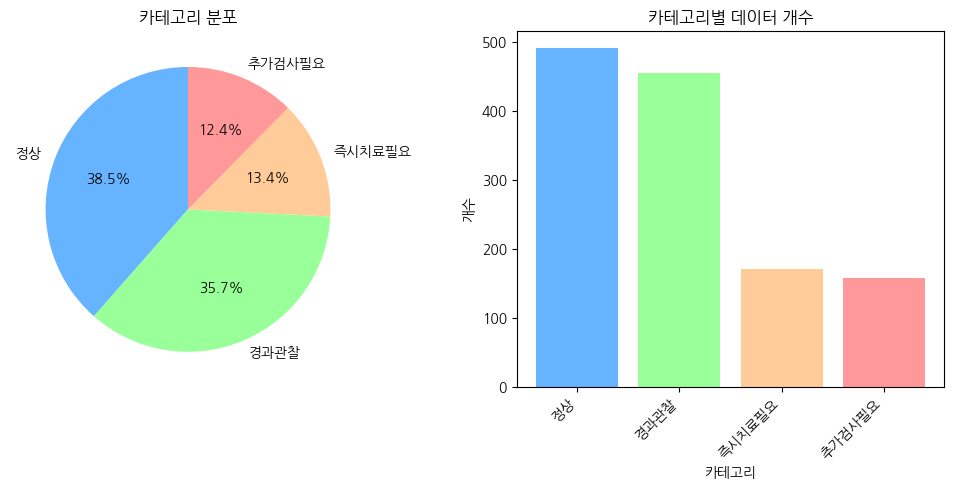


각 카테고리별 개수:
  정상: 491건 (38.5%)
  경과관찰: 455건 (35.7%)
  즉시치료필요: 171건 (13.4%)
  추가검사필요: 158건 (12.4%)


In [ ]:
# 레이블 분포 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
category_counts = df_clean['category'].value_counts()
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
        startangle=90, colors=['#66b3ff', '#99ff99', '#ffcc99', '#ff9999'])
plt.title('카테고리 분포')

plt.subplot(1, 2, 2)
plt.bar(category_counts.index, category_counts.values,
        color=['#66b3ff', '#99ff99', '#ffcc99', '#ff9999'])
plt.xlabel('카테고리')
plt.ylabel('개수')
plt.title('카테고리별 데이터 개수')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"\n각 카테고리별 개수:")
for category, count in category_counts.items():
    print(f"  {category}: {count}건 ({count/len(df_clean)*100:.1f}%)")

---

## 5. Train/Test 데이터 분할

**전략**:
- 80% Train, 20% Test 분할
- stratify 옵션으로 각 카테고리 비율 유지

In [ ]:
print("=" * 70)
print("Train/Test 데이터 분할")
print("=" * 70)

# 데이터 분할
X = df_clean['text'].values
y = df_clean['category'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # 클래스 비율 유지
)

print(f"\nTrain 데이터: {len(X_train):,}건")
print(f"Test 데이터: {len(X_test):,}건")

# Train/Test 레이블 분포 확인
print("\nTrain 레이블 분포:")
train_dist = pd.Series(y_train).value_counts()
for label, count in train_dist.items():
    print(f"  {label}: {count}건 ({count/len(y_train)*100:.1f}%)")

print("\nTest 레이블 분포:")
test_dist = pd.Series(y_test).value_counts()
for label, count in test_dist.items():
    print(f"  {label}: {count}건 ({count/len(y_test)*100:.1f}%)")

Train/Test 데이터 분할

Train 데이터: 1,020건
Test 데이터: 255건

Train 레이블 분포:
  정상: 393건 (38.5%)
  경과관찰: 364건 (35.7%)
  즉시치료필요: 137건 (13.4%)
  추가검사필요: 126건 (12.4%)

Test 레이블 분포:
  정상: 98건 (38.4%)
  경과관찰: 91건 (35.7%)
  즉시치료필요: 34건 (13.3%)
  추가검사필요: 32건 (12.5%)


---

## 6. TF-IDF 벡터화

**TF-IDF (Term Frequency-Inverse Document Frequency)**:
- 단어의 중요도를 계산하는 방법
- 자주 등장하지만 여러 문서에 공통으로 나타나는 단어는 중요도 낮음
- 특정 문서에만 나타나는 단어는 중요도 높음

**설정**:
- max_features=1000: 상위 1000개 단어만 사용
- ngram_range=(1,2): 1-gram(단어)과 2-gram(단어 쌍) 모두 고려
- min_df=2: 최소 2개 문서에 등장하는 단어만 사용

In [ ]:
print("=" * 70)
print("TF-IDF 벡터화")
print("=" * 70)

# TF-IDF Vectorizer 생성
vectorizer = TfidfVectorizer(
    max_features=1000,      # 상위 1000개 특성만 사용
    ngram_range=(1, 2),     # 1-gram과 2-gram 사용
    min_df=2,               # 최소 2개 문서에 등장해야 함
    sublinear_tf=True       # TF에 log 스케일 적용
)

# Train 데이터로 fit & transform
X_train_tfidf = vectorizer.fit_transform(X_train)

# Test 데이터는 transform만 (fit은 train에서만!)
X_test_tfidf = vectorizer.transform(X_test)

print(f"\nTrain 벡터 shape: {X_train_tfidf.shape}")
print(f"Test 벡터 shape: {X_test_tfidf.shape}")
print(f"전체 특성(단어/구문) 수: {len(vectorizer.get_feature_names_out())}")

TF-IDF 벡터화

Train 벡터 shape: (1020, 1000)
Test 벡터 shape: (255, 1000)
전체 특성(단어/구문) 수: 1000


In [ ]:
# 가장 중요한 특성(단어/구문) 확인
feature_names = vectorizer.get_feature_names_out()

print("\n상위 30개 특성(단어/구문):")
for i, feature in enumerate(feature_names[:30]):
    print(f"{i+1:2d}. {feature}")


상위 30개 특성(단어/구문):
 1. 0cm
 2. 0cm 크기의
 3. 10mm
 4. 10mm 크기의
 5. 11mm
 6. 11mm 크기의
 7. 12mm
 8. 12mm 크기의
 9. 13mm
10. 14mm
11. 1cm
12. 1cm 크기의
13. 1년
14. 1년 추적
15. 2cm
16. 2cm 크기의
17. 2cm입니다
18. 3cm
19. 3cm 크기의
20. 3개월
21. 3개월 추적
22. 57
23. 58
24. 59
25. 5cm
26. 5cm 크기의
27. 5cm입니다
28. 5mm
29. 5mm 크기의
30. 5로


---

## 7. Logistic Regression 모델 학습

**Logistic Regression**:
- 선형 모델 기반의 분류 알고리즘
- 빠르고 해석이 쉬움
- Multi-class 분류 지원

**설정**:
- max_iter=1000: 최대 반복 횟수
- multi_class='multinomial': 다중 클래스 분류
- solver='lbfgs': 최적화 알고리즘

In [ ]:
print("=" * 70)
print("Logistic Regression 모델 학습")
print("=" * 70)

# 모델 생성
model = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42
)

# 모델 학습
print("\n모델 학습 중...")
model.fit(X_train_tfidf, y_train)
print("✓ 학습 완료!")

# 학습 파라미터 정보
print(f"\n모델 정보:")
print(f"  클래스 개수: {len(model.classes_)}")
print(f"  클래스: {model.classes_}")
print(f"  반복 횟수: {model.n_iter_}")

Logistic Regression 모델 학습

모델 학습 중...
✓ 학습 완료!

모델 정보:
  클래스 개수: 4
  클래스: ['경과관찰' '정상' '즉시치료필요' '추가검사필요']
  반복 횟수: [27]


---

## 8. 성능 평가

**평가 지표**:
- **Accuracy**: 전체 중 맞춘 비율
- **F1-Score**: Precision과 Recall의 조화평균
  - Precision: 예측한 것 중 맞춘 비율
  - Recall: 실제 정답 중 맞춘 비율

In [ ]:
print("=" * 70)
print("모델 성능 평가")
print("=" * 70)

# 예측
y_train_pred = model.predict(X_train_tfidf)
y_test_pred = model.predict(X_test_tfidf)

# Accuracy 계산
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# F1-Score 계산 (macro: 각 클래스별 F1의 평균)
train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print("\n📊 성능 지표:")
print(f"\n[Train 데이터]")
print(f"  Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  F1-Score (macro): {train_f1:.4f}")

print(f"\n[Test 데이터]")
print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  F1-Score (macro): {test_f1:.4f}")

# Overfitting 체크
accuracy_diff = train_accuracy - test_accuracy
print(f"\n⚠️ Train-Test Accuracy 차이: {accuracy_diff:.4f}")
if accuracy_diff > 0.1:
    print("   → Overfitting 가능성 있음 (차이가 10% 이상)")
else:
    print("   → 적절한 일반화 성능")

모델 성능 평가

📊 성능 지표:

[Train 데이터]
  Accuracy: 0.9824 (98.24%)
  F1-Score (macro): 0.9723

[Test 데이터]
  Accuracy: 0.9765 (97.65%)
  F1-Score (macro): 0.9601

⚠️ Train-Test Accuracy 차이: 0.0059
   → 적절한 일반화 성능


---

## 9. 상세 분류 리포트

In [ ]:
print("=" * 70)
print("상세 분류 리포트")
print("=" * 70)

# 분류 리포트 출력
print("\n[Test 데이터 분류 리포트]\n")
report = classification_report(y_test, y_test_pred, target_names=model.classes_)
print(report)

# 클래스별 성능을 데이터프레임으로 정리
report_dict = classification_report(y_test, y_test_pred, target_names=model.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

상세 분류 리포트

[Test 데이터 분류 리포트]

              precision    recall  f1-score   support

        경과관찰       0.97      1.00      0.98        91
          정상       1.00      1.00      1.00        98
      즉시치료필요       0.94      0.97      0.96        34
      추가검사필요       0.96      0.84      0.90        32

    accuracy                           0.98       255
   macro avg       0.97      0.95      0.96       255
weighted avg       0.98      0.98      0.98       255



,precision,recall,f1-score,support
경과관찰,0.968085,1.000000,0.983784,91.000000
정상,1.000000,1.000000,1.000000,98.000000
즉시치료필요,0.942857,0.970588,0.956522,34.000000
추가검사필요,0.964286,0.843750,0.900000,32.000000
accuracy,0.976471,0.976471,0.976471,0.976471
macro avg,0.968807,0.953585,0.960076,255.000000
weighted avg,0.976510,0.976471,0.975867,255.000000


---

## 10. Confusion Matrix (혼동 행렬)

**Confusion Matrix**:
- 예측 결과를 시각적으로 분석
- 어떤 클래스를 어떤 클래스로 잘못 예측했는지 확인

Confusion Matrix (혼동 행렬)


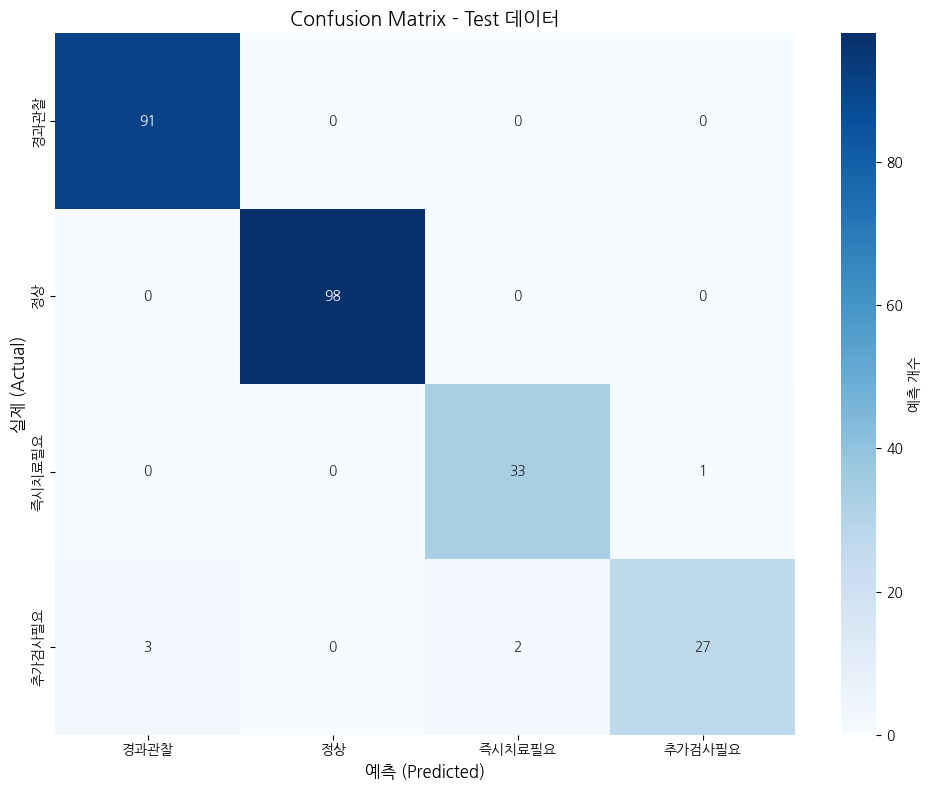


혼동 행렬 해석:
  '즉시치료필요'를 '추가검사필요'로 잘못 예측: 1건
  '추가검사필요'를 '경과관찰'로 잘못 예측: 3건
  '추가검사필요'를 '즉시치료필요'로 잘못 예측: 2건


In [ ]:
print("=" * 70)
print("Confusion Matrix (혼동 행렬)")
print("=" * 70)

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_test_pred, labels=model.classes_)

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_,
            cbar_kws={'label': '예측 개수'})
plt.xlabel('예측 (Predicted)', fontsize=12)
plt.ylabel('실제 (Actual)', fontsize=12)
plt.title('Confusion Matrix - Test 데이터', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 혼동 행렬 해석
print("\n혼동 행렬 해석:")
for i, true_label in enumerate(model.classes_):
    for j, pred_label in enumerate(model.classes_):
        if i != j and cm[i][j] > 0:
            print(f"  '{true_label}'를 '{pred_label}'로 잘못 예측: {cm[i][j]}건")

---

## 11. 예측 확률 분석

Logistic Regression은 각 클래스별 확률을 제공합니다.

In [ ]:
print("=" * 70)
print("예측 확률 분석")
print("=" * 70)

# 예측 확률 계산
y_test_proba = model.predict_proba(X_test_tfidf)

# 샘플 5개의 예측 확률 출력
print("\nTest 샘플 5개의 예측 확률:\n")
for i in range(5):
    print(f"[샘플 {i+1}]")
    print(f"  텍스트: {X_test[i][:60]}...")
    print(f"  실제 레이블: {y_test[i]}")
    print(f"  예측 레이블: {y_test_pred[i]}")
    print(f"  예측 확률:")
    for label, prob in zip(model.classes_, y_test_proba[i]):
        print(f"    {label}: {prob:.4f} ({prob*100:.2f}%)")
    print()

예측 확률 분석

Test 샘플 5개의 예측 확률:

[샘플 1]
  텍스트: 흉부 CT에서 양측 폐야는 깨끗하며 특이 소견 없습니다. 심장 크기는 정상이고 종격동 구조물도 정상입니다. ...
  실제 레이블: 정상
  예측 레이블: 정상
  예측 확률:
    경과관찰: 0.0137 (1.37%)
    정상: 0.9690 (96.90%)
    즉시치료필요: 0.0089 (0.89%)
    추가검사필요: 0.0084 (0.84%)

[샘플 2]
  텍스트: 우측 폐상엽에 약 11mm 크기의 결절이 보입니다. 폐결절. 3개월 후 추적 검사 권장합니다....
  실제 레이블: 경과관찰
  예측 레이블: 경과관찰
  예측 확률:
    경과관찰: 0.8633 (86.33%)
    정상: 0.0311 (3.11%)
    즉시치료필요: 0.0393 (3.93%)
    추가검사필요: 0.0663 (6.63%)

[샘플 3]
  텍스트: 간 실질은 전반적으로 에코가 증가되어 있어 중등도 지방간 소견이 관찰됩니다. 담낭, 췌장, 비장, 양측 신장...
  실제 레이블: 경과관찰
  예측 레이블: 경과관찰
  예측 확률:
    경과관찰: 0.7026 (70.26%)
    정상: 0.1360 (13.60%)
    즉시치료필요: 0.0531 (5.31%)
    추가검사필요: 0.1083 (10.83%)

[샘플 4]
  텍스트: 간 실질 에코가 미만성으로 증가되어 있습니다. 지방간 소견입니다. 지방간. 식이요법 및 운동 권장합니다....
  실제 레이블: 경과관찰
  예측 레이블: 경과관찰
  예측 확률:
    경과관찰: 0.9059 (90.59%)
    정상: 0.0319 (3.19%)
    즉시치료필요: 0.0279 (2.79%)
    추가검사필요: 0.0343 (3.43%)

[샘플 5]
  텍스트: 우측 폐상엽에 약 10mm 크기의 결절이 보입니다. 폐결절. 6개월 후 추적 CT 권장합니다....
  실제 레이블: 경과관찰
  예측 레이블: 경과관

---

## 12. 오분류 사례 분석

모델이 잘못 예측한 케이스를 분석하여 개선점을 찾습니다.

In [ ]:
print("=" * 70)
print("오분류 사례 분석")
print("=" * 70)

# 오분류된 샘플 찾기
misclassified_idx = np.where(y_test != y_test_pred)[0]

print(f"\n오분류 개수: {len(misclassified_idx)}건 ({len(misclassified_idx)/len(y_test)*100:.1f}%)")

if len(misclassified_idx) > 0:
    print("\n오분류 샘플 (상위 5개):\n")
    for i, idx in enumerate(misclassified_idx[:5]):
        print(f"[오분류 {i+1}]")
        print(f"  텍스트: {X_test[idx][:80]}...")
        print(f"  실제: {y_test[idx]}")
        print(f"  예측: {y_test_pred[idx]}")
        print(f"  예측 확률:")
        for label, prob in zip(model.classes_, y_test_proba[idx]):
            marker = " ← 예측" if label == y_test_pred[idx] else ""
            marker += " (정답)" if label == y_test[idx] else ""
            print(f"    {label}: {prob:.4f} ({prob*100:.1f}%){marker}")
        print()

오분류 사례 분석

오분류 개수: 6건 (2.4%)

오분류 샘플 (상위 5개):

[오분류 1]
  텍스트: 간 실질은 전반적으로 에코가 현저히 증가되어 심한 지방간 소견입니다. 비장은 약간 비대되어 있습니다(13cm). 심한 지방간 및 경미한 비장비대...
  실제: 추가검사필요
  예측: 경과관찰
  예측 확률:
    경과관찰: 0.7677 (76.8%) ← 예측
    정상: 0.0461 (4.6%)
    즉시치료필요: 0.0689 (6.9%)
    추가검사필요: 0.1173 (11.7%) (정답)

[오분류 2]
  텍스트: 심장 음영이 약간 증가되어 있습니다. 심비대 가능성이 있어 추가 검사 권장합니다. 심비대 의심. 심장 초음파 검사 권장합니다....
  실제: 추가검사필요
  예측: 경과관찰
  예측 확률:
    경과관찰: 0.5091 (50.9%) ← 예측
    정상: 0.0923 (9.2%)
    즉시치료필요: 0.0560 (5.6%)
    추가검사필요: 0.3425 (34.3%) (정답)

[오분류 3]
  텍스트: L3-4, L4-5 레벨에서 척추관 협착증이 관찰됩니다. 다분절 협착 소견입니다. 다분절 척추관 협착증. 정형외과 진료 및 치료가 필요합니다....
  실제: 즉시치료필요
  예측: 추가검사필요
  예측 확률:
    경과관찰: 0.1140 (11.4%)
    정상: 0.0869 (8.7%)
    즉시치료필요: 0.1852 (18.5%) (정답)
    추가검사필요: 0.6139 (61.4%) ← 예측

[오분류 4]
  텍스트: 간 우엽에 약 1.5cm 크기의 결절이 관찰됩니다. 재생결절 또는 이형성결절 의심됩니다. 간 결절. 간담도내과 진료 및 추적관찰이 필요합니다....
  실제: 추가검사필요
  예측: 경과관찰
  예측 확률:
    경과관찰: 0.4759 (47.6%) ← 예측
    정상: 0.0375 (3.7%)
    즉시치료필요: 0.1315 (13.2%)
    추가검사필요: 0.3550 (35

---

## 13. 특성 중요도 분석

각 카테고리 예측에 가장 영향을 많이 주는 단어를 확인합니다.

In [ ]:
print("=" * 70)
print("특성 중요도 분석")
print("=" * 70)

# 각 클래스별 가장 중요한 특성(단어) 추출
feature_names = np.array(vectorizer.get_feature_names_out())

print("\n각 카테고리별 중요 단어 TOP 10:\n")
for i, category in enumerate(model.classes_):
    print(f"[{category}]")

    # 해당 클래스에 대한 계수(가중치) 가져오기
    coef = model.coef_[i]

    # 계수가 큰 순서대로 정렬
    top_indices = np.argsort(coef)[-10:][::-1]
    top_features = feature_names[top_indices]
    top_coefs = coef[top_indices]

    for rank, (feature, weight) in enumerate(zip(top_features, top_coefs), 1):
        print(f"  {rank:2d}. {feature:20s} (가중치: {weight:6.3f})")
    print()

특성 중요도 분석

각 카테고리별 중요 단어 TOP 10:

[경과관찰]
   1. 권장합니다                (가중치:  2.317)
   2. 경미한                  (가중치:  1.449)
   3. 지방간                  (가중치:  1.324)
   4. 양성                   (가중치:  1.266)
   5. 추적관찰                 (가중치:  1.224)
   6. 추적관찰 권장합니다           (가중치:  1.200)
   7. 증상 발생                (가중치:  1.007)
   8. 발생                   (가중치:  1.007)
   9. 발생 외과                (가중치:  1.007)
  10. 추적                   (가중치:  0.979)

[정상]
   1. 정상                   (가중치:  2.964)
   2. 소견입니다                (가중치:  2.049)
   3. 없습니다 정상              (가중치:  1.363)
   4. 초음파 소견입니다            (가중치:  1.351)
   5. 심장                   (가중치:  1.317)
   6. 없습니다                 (가중치:  1.189)
   7. 양측                   (가중치:  1.182)
   8. 초음파                  (가중치:  1.133)
   9. 흉부                   (가중치:  1.132)
  10. 정상 흉부                (가중치:  1.119)

[즉시치료필요]
   1. 급성                   (가중치:  1.401)
   2. 치료가                  (가중치:  1.332)
   3. 치료가 필요합니다            (가중치:  1.332)


---

## 14. 실전 예측 테스트

새로운 판독문 샘플로 모델을 테스트해봅니다.

In [ ]:
print("=" * 70)
print("실전 예측 테스트")
print("=" * 70)

# 새로운 판독문 샘플
new_samples = [
    "양측 폐야는 전반적으로 깨끗합니다. 심장 크기는 정상 범위입니다. 특이 소견 없습니다.",
    "우측 폐상엽에 약 6mm 크기의 미세 결절이 관찰됩니다. 1년 후 추적 검사 권장합니다.",
    "좌하엽에 경화 소견이 있습니다. 폐렴 의심. 항생제 치료 권장합니다.",
    "우측 폐중엽에 약 12mm 크기의 결절이 관찰됩니다. 추가 정밀검사가 필요합니다."
]

# 예측
new_samples_tfidf = vectorizer.transform(new_samples)
new_predictions = model.predict(new_samples_tfidf)
new_probas = model.predict_proba(new_samples_tfidf)

print("\n새로운 판독문 예측 결과:\n")
for i, sample in enumerate(new_samples):
    print(f"[샘플 {i+1}]")
    print(f"  판독문: {sample}")
    print(f"  예측: {new_predictions[i]}")
    print(f"  확률:")
    for label, prob in zip(model.classes_, new_probas[i]):
        marker = " ← 예측" if label == new_predictions[i] else ""
        print(f"    {label}: {prob:.4f} ({prob*100:.1f}%){marker}")
    print()

실전 예측 테스트

새로운 판독문 예측 결과:

[샘플 1]
  판독문: 양측 폐야는 전반적으로 깨끗합니다. 심장 크기는 정상 범위입니다. 특이 소견 없습니다.
  예측: 정상
  확률:
    경과관찰: 0.0231 (2.3%)
    정상: 0.9463 (94.6%) ← 예측
    즉시치료필요: 0.0156 (1.6%)
    추가검사필요: 0.0150 (1.5%)

[샘플 2]
  판독문: 우측 폐상엽에 약 6mm 크기의 미세 결절이 관찰됩니다. 1년 후 추적 검사 권장합니다.
  예측: 경과관찰
  확률:
    경과관찰: 0.8922 (89.2%) ← 예측
    정상: 0.0225 (2.2%)
    즉시치료필요: 0.0344 (3.4%)
    추가검사필요: 0.0510 (5.1%)

[샘플 3]
  판독문: 좌하엽에 경화 소견이 있습니다. 폐렴 의심. 항생제 치료 권장합니다.
  예측: 즉시치료필요
  확률:
    경과관찰: 0.1645 (16.5%)
    정상: 0.0527 (5.3%)
    즉시치료필요: 0.6988 (69.9%) ← 예측
    추가검사필요: 0.0839 (8.4%)

[샘플 4]
  판독문: 우측 폐중엽에 약 12mm 크기의 결절이 관찰됩니다. 추가 정밀검사가 필요합니다.
  예측: 경과관찰
  확률:
    경과관찰: 0.5603 (56.0%) ← 예측
    정상: 0.0490 (4.9%)
    즉시치료필요: 0.0971 (9.7%)
    추가검사필요: 0.2936 (29.4%)



---

## 15. 성능 비교 시각화

성능 비교 시각화


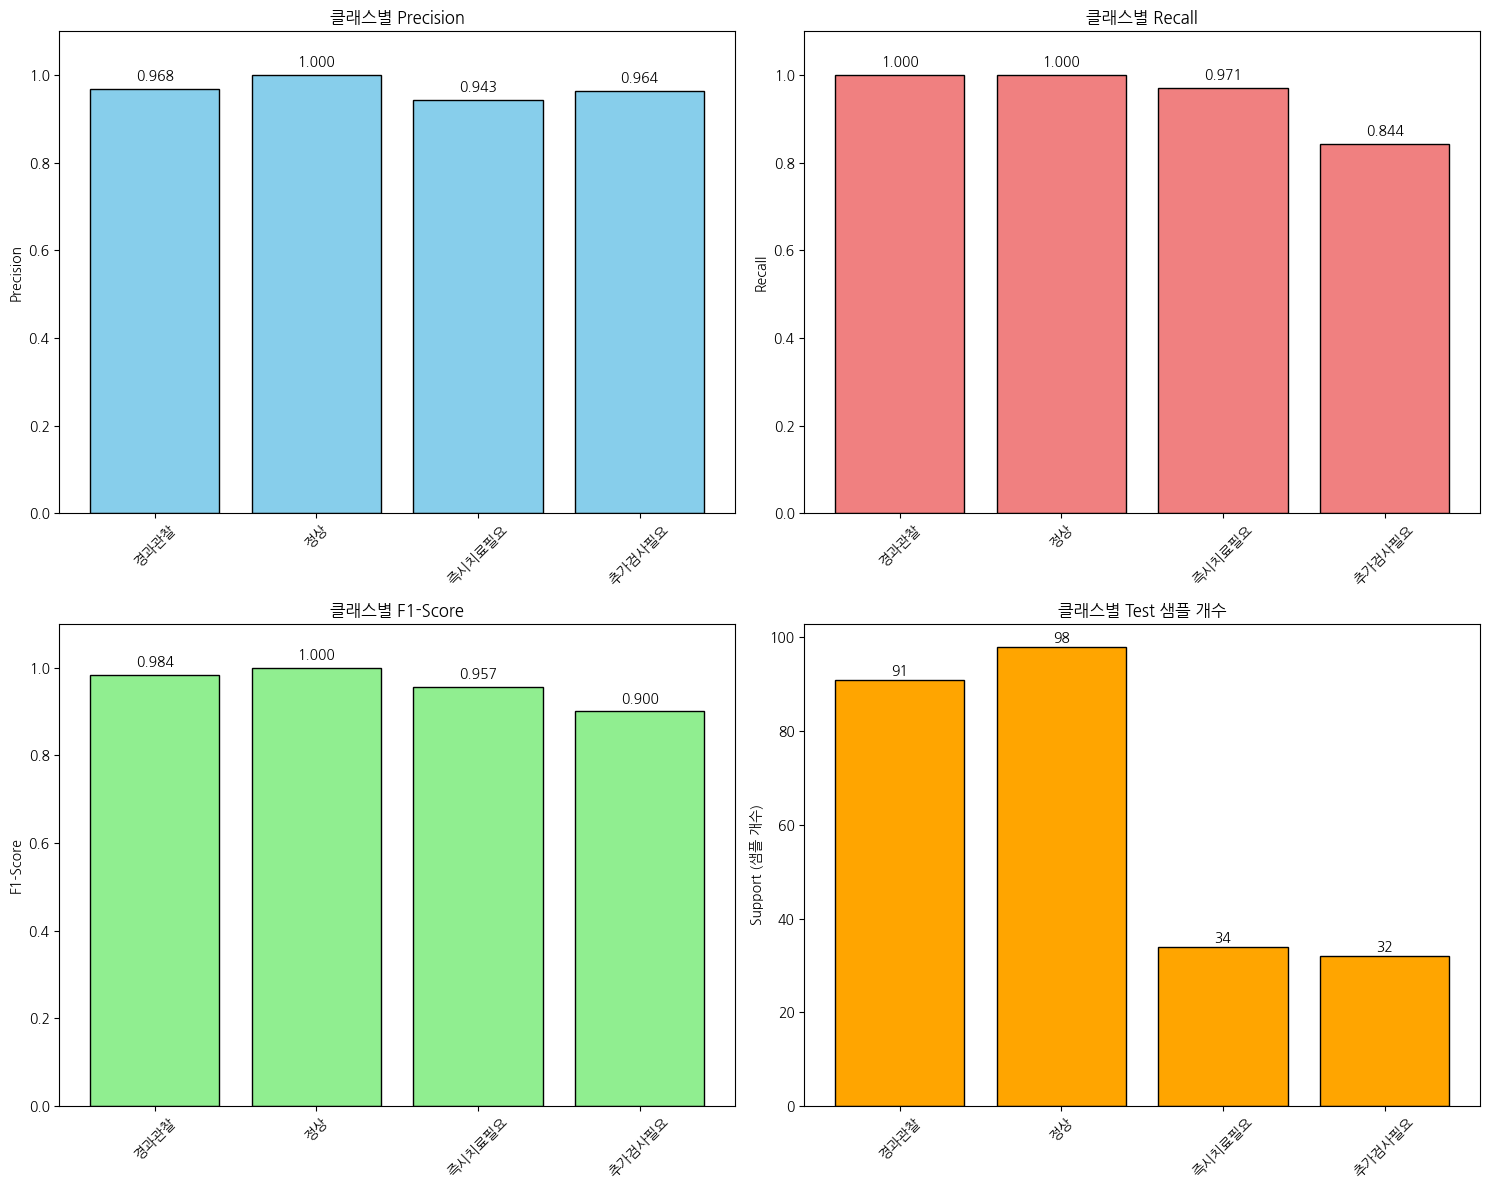

In [ ]:
print("=" * 70)
print("성능 비교 시각화")
print("=" * 70)

# 클래스별 성능 비교
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Precision 비교
axes[0, 0].bar(model.classes_,
               [report_dict[c]['precision'] for c in model.classes_],
               color='skyblue', edgecolor='black')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_title('클래스별 Precision', fontweight='bold')
axes[0, 0].set_ylim([0, 1.1])
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate([report_dict[c]['precision'] for c in model.classes_]):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

# 2. Recall 비교
axes[0, 1].bar(model.classes_,
               [report_dict[c]['recall'] for c in model.classes_],
               color='lightcoral', edgecolor='black')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_title('클래스별 Recall', fontweight='bold')
axes[0, 1].set_ylim([0, 1.1])
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate([report_dict[c]['recall'] for c in model.classes_]):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

# 3. F1-Score 비교
axes[1, 0].bar(model.classes_,
               [report_dict[c]['f1-score'] for c in model.classes_],
               color='lightgreen', edgecolor='black')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('클래스별 F1-Score', fontweight='bold')
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate([report_dict[c]['f1-score'] for c in model.classes_]):
    axes[1, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

# 4. Support (샘플 개수) 비교
axes[1, 1].bar(model.classes_,
               [report_dict[c]['support'] for c in model.classes_],
               color='orange', edgecolor='black')
axes[1, 1].set_ylabel('Support (샘플 개수)')
axes[1, 1].set_title('클래스별 Test 샘플 개수', fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate([report_dict[c]['support'] for c in model.classes_]):
    axes[1, 1].text(i, v + 1, f'{int(v)}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

---

## 16. 모델 저장

학습된 모델과 벡터라이저를 저장하여 나중에 재사용할 수 있습니다.

In [ ]:
import pickle

print("=" * 70)
print("모델 저장")
print("=" * 70)

# 저장 경로
if IN_COLAB:
    model_path = 'logistic_regression_model.pkl'
    vectorizer_path = 'tfidf_vectorizer.pkl'
else:
    model_path = '../../../models/logistic_regression_model.pkl'
    vectorizer_path = '../../../models/tfidf_vectorizer.pkl'

    # 디렉토리 생성
    os.makedirs(os.path.dirname(model_path), exist_ok=True)

# 모델 저장
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"✓ 모델 저장 완료: {model_path}")

# 벡터라이저 저장
with open(vectorizer_path, 'wb') as f:
    pickle.dump(vectorizer, f)
print(f"✓ 벡터라이저 저장 완료: {vectorizer_path}")

모델 저장
✓ 모델 저장 완료: logistic_regression_model.pkl
✓ 벡터라이저 저장 완료: tfidf_vectorizer.pkl


---

## 17. 결과 요약

In [ ]:
print("=" * 70)
print("결과 요약")
print("=" * 70)

print("\n📊 전체 성능 지표:")
print(f"  - Train Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  - Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  - Train F1-Score: {train_f1:.4f}")
print(f"  - Test F1-Score:  {test_f1:.4f}")

print("\n🎯 클래스별 최고 성능:")
best_precision_class = max(model.classes_, key=lambda c: report_dict[c]['precision'])
best_recall_class = max(model.classes_, key=lambda c: report_dict[c]['recall'])
best_f1_class = max(model.classes_, key=lambda c: report_dict[c]['f1-score'])

print(f"  - 최고 Precision: {best_precision_class} ({report_dict[best_precision_class]['precision']:.4f})")
print(f"  - 최고 Recall:    {best_recall_class} ({report_dict[best_recall_class]['recall']:.4f})")
print(f"  - 최고 F1-Score:  {best_f1_class} ({report_dict[best_f1_class]['f1-score']:.4f})")

print("\n⚠️ 개선 필요 클래스:")
worst_f1_class = min(model.classes_, key=lambda c: report_dict[c]['f1-score'])
print(f"  - 최저 F1-Score: {worst_f1_class} ({report_dict[worst_f1_class]['f1-score']:.4f})")

print("\n💾 저장된 파일:")
print(f"  - 모델: {model_path}")
print(f"  - 벡터라이저: {vectorizer_path}")

print("\n" + "=" * 70)
print("실습 완료!")
print("=" * 70)

결과 요약

📊 전체 성능 지표:
  - Train Accuracy: 0.9824 (98.24%)
  - Test Accuracy:  0.9765 (97.65%)
  - Train F1-Score: 0.9723
  - Test F1-Score:  0.9601

🎯 클래스별 최고 성능:
  - 최고 Precision: 정상 (1.0000)
  - 최고 Recall:    경과관찰 (1.0000)
  - 최고 F1-Score:  정상 (1.0000)

⚠️ 개선 필요 클래스:
  - 최저 F1-Score: 추가검사필요 (0.9000)

💾 저장된 파일:
  - 모델: logistic_regression_model.pkl
  - 벡터라이저: tfidf_vectorizer.pkl

실습 완료!


---

## 18. 핵심 정리

### 학습한 내용

1. **텍스트 전처리**
   - 판독문(findings) + 판독의견(impression) 결합
   - Train/Test 분할 (80:20)
   - Stratified split으로 클래스 비율 유지

2. **TF-IDF 벡터화**
   - 단어의 중요도를 수치화
   - 1-gram과 2-gram 조합
   - 상위 1000개 특성 선택

3. **Logistic Regression**
   - 빠르고 효율적인 선형 분류 모델
   - Multi-class 분류 지원
   - 각 클래스별 확률 제공

4. **성능 평가**
   - Accuracy: 전체 정확도
   - F1-Score: Precision과 Recall의 조화평균
   - Confusion Matrix: 예측 오류 패턴 분석

### 실무 활용 팁

- **데이터 불균형 처리**: 클래스별 샘플 수가 다를 경우 가중치 조정 필요
- **특성 선택**: TF-IDF의 max_features 조정으로 성능 개선 가능
- **하이퍼파라미터 튜닝**: C 값, solver 변경으로 성능 최적화
- **앙상블**: 여러 모델을 결합하여 성능 향상